# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import time

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(true, pred, num_classes=10):
    """
    Compute the confusion matrix for a batch of predictions.
    
    Args:
    - true (torch.Tensor): The ground-truth labels.
    - pred (torch.Tensor): The predicted labels.
    - num_classes (int): The number of classes.
    
    Returns:
    - (np.ndarray): The confusion matrix.
    """
    matrix = np.zeros((num_classes, num_classes))
    
    stacked = np.vstack((true.cpu().numpy(), pred.cpu().numpy()))
    for true_label, pred_label in stacked.T:
        matrix[true_label, pred_label] += 1
        
    return matrix

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [4]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 32  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([32, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([32, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

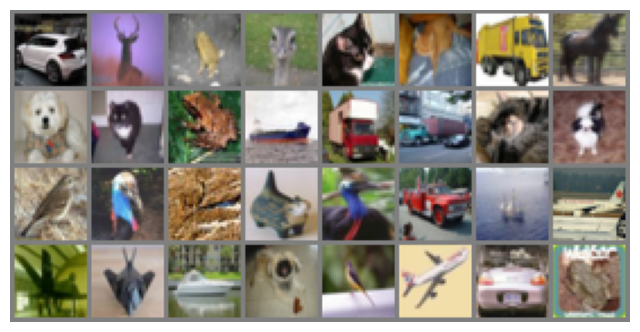

In [6]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [7]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=1),  # Increased channels
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1),  # Increased channels
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.AvgPool2d(kernel_size=2, stride=2),  # Changed to Average Pooling

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Added new layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),  # Increased channels
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 1024),  # Adjusted due to new layer and increased channels
            nn.LeakyReLU(negative_slope=0.01)   ,
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x




In [8]:
model = Model(n_classes)
device = torch.device('cuda')
model.to(device)
print(model)


Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.35, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.35, inplace=False)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout(p=0.35, inplace=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): 

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [9]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.90, 0.999), weight_decay=2.5e-4)
loss_fn = nn.CrossEntropyLoss()

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [10]:
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.13110209 -0.1373048   0.0815645   0.21550383  0.14521813 -0.0067867
  -0.15540004 -0.72644556 -0.63782877 -0.26574832]
 [ 0.39602664 -0.2887896  -0.644583    0.14588098 -0.5669767   0.19480586
  -0.3055877  -0.274454   -0.22521552  0.08235916]]
Output probabilities:
[[0.09901433 0.09840206 0.12247796 0.14003192 0.1305276  0.11212114
  0.09663748 0.05459384 0.05965261 0.086541  ]
 [0.16364278 0.08250588 0.05780506 0.12742656 0.06246975 0.13381591
  0.08113151 0.08369717 0.08792145 0.11958391]]


--------------Epoch: 1/50, Time: 2.57--------------
Step 0       training accuracy: 0.1250
             test accuracy: 0.1206
--------------Epoch: 1/50, Time: 19.69--------------
Step 500     training accuracy: 0.3764
             test accuracy: 0.4445
--------------Epoch: 1/50, Time: 38.18--------------
Step 1000    training accuracy: 0.4950
             test accuracy: 0.4779
--------------Epoch: 1/50, Time: 57.50--------------
Step 1500    training accuracy: 0.5514
             test accuracy: 0.5311
--------------Epoch: 2/50, Time: 76.84--------------
Step 2000    training accuracy: 0.5939
             test accuracy: 0.6176
--------------Epoch: 2/50, Time: 96.20--------------
Step 2500    training accuracy: 0.6228
             test accuracy: 0.6393
--------------Epoch: 2/50, Time: 115.59--------------
Step 3000    training accuracy: 0.6379
             test accuracy: 0.6411
--------------Epoch: 3/50, Time: 134.99--------------
Step 3500    training accuracy: 0.6648
             test 

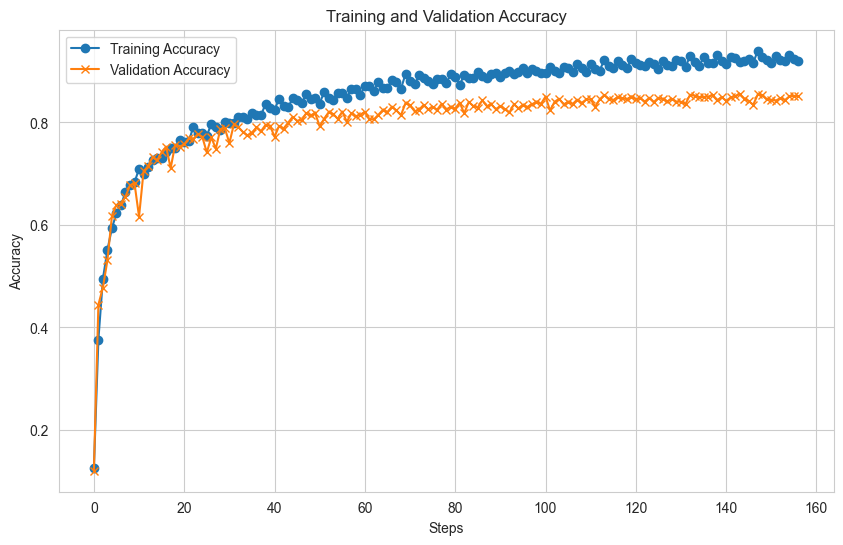

In [271]:
num_epochs = 50
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

start_time  = time.time()

def accuracy(targets, predictions):
    return (targets == predictions).float().mean().item()

for epoch in range(num_epochs):
    train_accuracies_batches = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
            
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()
            
            end_time = time.time()  # Record end time
    
            epoch_duration = end_time - start_time
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
            print(f"--------------Epoch: {epoch+1}/{num_epochs}, Time: {epoch_duration:.2f}--------------")
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")
        
        step += 1

print("Finished training.")

steps = list(range(len(valid_accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(steps, valid_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

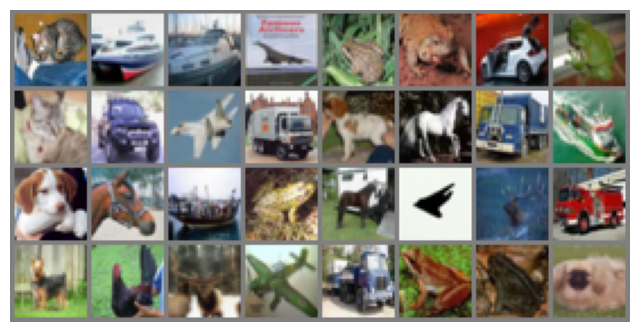

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          frog     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     


In [272]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [273]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()




Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [274]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.854


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


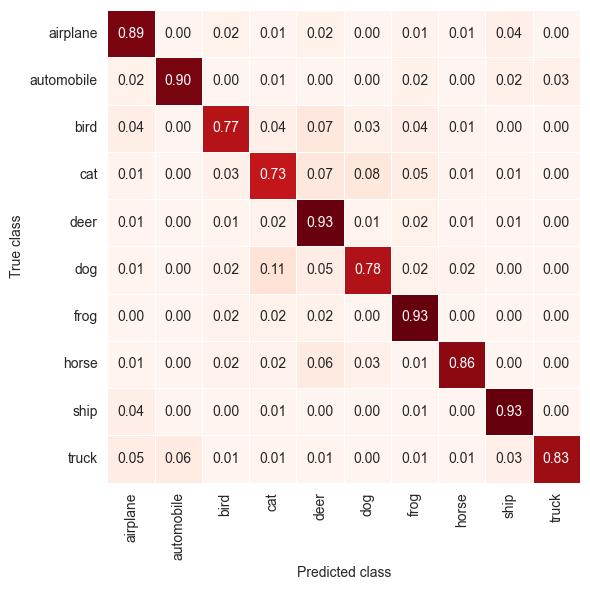

In [275]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

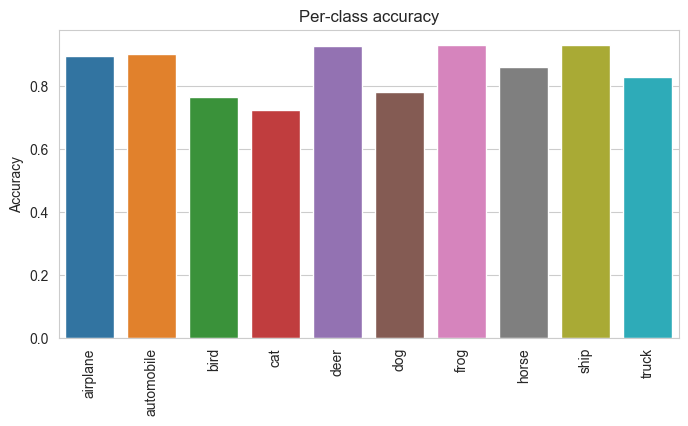

In [276]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

# **Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

# **Answer:**


1. Results
Training accuracy peaked at 91.98% by the 50th epoch, with a test accuracy of 85.15% on CIFAR-10. The model is still overfitting but is capturing the underlying patterns in the data


2. Actions, Experiments, and Results:
Modifications:
- Model Architecture: Transitioned from a basic CNN to a deeper one with multiple convolutional layers. 
- Filters: Increased the depth by adjusting the number of filters in convolutional layers.
- Kernel Sizes: Experimented with sizes, finding optimal spatial dimensions for feature extraction.
- Activation: Adopted LeakyReLU over ReLU for improved gradient flow in deeper networks.
- Normalization & Regularization: Integrated batch normalization for stabilization and dropout to combat overfitting.
- Pooling: Leveraged both max pooling and average pooling to diversify feature extraction.
- Hyperparameters: Adjusted learning rate (1e-4 to 2e-4) and weight decay (1e-4 to 2e-4) for stable convergence.

3. Key Insights:
- Model Depth: Model depths helps to capture the underlying patterns however increasing it both makes it easier to overfit but also increases training time. You should only increase neurons or keep the same for each convenlutional layer.
- Batch: Batch normalization improves training. Furthermore, reducing batch sizing can act as a regularizer for overfitting.
- Regularization Techniques: Dropout and weight decay are effective methods for generalization, e.g. combat overfitting.
- **Key take away: Make a complex model but be prepared to take every precaution to make sure it does not overfit**


# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





In [15]:
class ConvOnlyModel(nn.Module):
    def __init__(self, num_classes):
        super(ConvOnlyModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.35)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



model = Model(n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.90, 0.999), weight_decay=2.5e-4)
loss_fn = nn.CrossEntropyLoss()

In [17]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.03168276  0.30183074  0.00484896 -0.35794115 -0.08022119 -0.00812624
  -0.14477342  0.13026474  0.12021218  0.08292066]
 [ 0.18934993  0.05725164  0.09257659 -0.3748312   0.15205589 -0.19074014
   0.02507335 -0.10689922  0.17652494 -0.09562563]]
Output probabilities:
[[0.10097873 0.13229813 0.09830512 0.06839406 0.09028812 0.09703784
  0.08464395 0.11144061 0.11032596 0.10628752]
 [0.12002736 0.10517455 0.10895624 0.06827465 0.1156335  0.08207469
  0.10184408 0.08925259 0.11849783 0.09026448]]


--------------Epoch: 1/50, Time: 3.10--------------
Step 0       training accuracy: 0.1562
             test accuracy: 0.1337
--------------Epoch: 1/50, Time: 9.21--------------
Step 500     training accuracy: 0.3834
             test accuracy: 0.4315
--------------Epoch: 1/50, Time: 15.24--------------
Step 1000    training accuracy: 0.4487
             test accuracy: 0.4526
--------------Epoch: 1/50, Time: 21.33--------------
Step 1500    training accuracy: 0.4594
             test accuracy: 0.4718
--------------Epoch: 2/50, Time: 27.44--------------
Step 2000    training accuracy: 0.5080
             test accuracy: 0.4843
--------------Epoch: 2/50, Time: 33.58--------------
Step 2500    training accuracy: 0.5048
             test accuracy: 0.4928
--------------Epoch: 2/50, Time: 39.66--------------
Step 3000    training accuracy: 0.5157
             test accuracy: 0.5003
--------------Epoch: 3/50, Time: 45.93--------------
Step 3500    training accuracy: 0.5570
             test acc

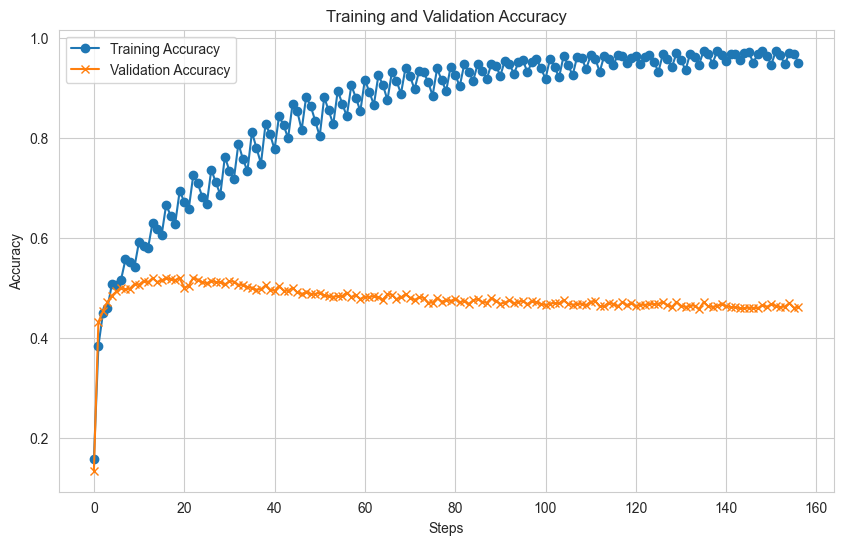

In [18]:
num_epochs = 50
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

start_time  = time.time()

def accuracy(targets, predictions):
    return (targets == predictions).float().mean().item()

for epoch in range(num_epochs):
    train_accuracies_batches = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
            
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()
            
            end_time = time.time()  # Record end time
    
            epoch_duration = end_time - start_time
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
            print(f"--------------Epoch: {epoch+1}/{num_epochs}, Time: {epoch_duration:.2f}--------------")
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")
        
        step += 1

print("Finished training.")

steps = list(range(len(valid_accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(steps, valid_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
